In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from unet import UNet
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU number to use


def img_dir_load(img_path):
    result = []
    for file in tqdm( os.listdir(img_path) ):
        # img = image.load_img( os.path.join(img_path, file) )
        img = image.load_img( os.path.join(img_path, file), target_size=(256,256))
        img_tensor = image.img_to_array(img)
        # scaling into [0, 1]
        img_tensor /= 255.
        result.append(img_tensor)
    
    return np.array(result)

def mask_dir_load(img_path):
    result = []
    for file in tqdm( os.listdir(img_path) ):
        # img = image.load_img( os.path.join(img_path, file) )
        img = image.load_img( os.path.join(img_path, file), target_size=(256,256))
        img_tensor = image.img_to_array(img)
        img_tensor = tf.image.rgb_to_grayscale(img_tensor)
        # scaling into [0, 1]
        img_tensor /= 255.
        result.append(img_tensor)
    # result = np.array(result)
    # result = np.where(result>=0.5, 1, 0)
    return np.array(result)

In [2]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [3]:
img_path = "/home/pkwmay/202103_Hallym_leenuri/dataset/01_seg_train_dataset/image/"
mask_path = "/home/pkwmay/202103_Hallym_leenuri/dataset/01_seg_train_dataset/mask/"

img = img_dir_load(img_path)
mask = mask_dir_load(mask_path)
# mask = to_categorical(mask1)

  0%|          | 0/946 [00:00<?, ?it/s]2022-03-03 10:51:44.345424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 10:51:44.986744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14794 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3e:00.0, compute capability: 7.5
100%|██████████| 946/946 [00:14<00:00, 66.92it/s]


In [4]:
x_train, x_test, y_train, y_test = train_test_split(img, mask, test_size=0.2, random_state=777)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(756, 256, 256, 3)
(190, 256, 256, 3)
(756, 256, 256, 1)
(190, 256, 256, 1)


# Modeling & Run

In [46]:
#option
batch_size = 1
epochs = 50
lr = 1e-4

In [47]:
model = UNet(input_size=x_train.shape[1:], num_cls=1)
model.summary()
model.compile(optimizer = Adam(lr), loss=dice_loss, metrics=[iou, dice_coef])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 256, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_95[0][0]']              
                                )                                                             

In [48]:
# # Failed because of performance reduction
# #Augmentaiton settings

# datagen = image.ImageDataGenerator(
#     width_shift_range=0.1,
#     height_shift_range=0.1
#     # horizontal_flip=True
# )

# datagen.fit(x_train)

In [49]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/50
756/756 [==============================] - 51s 66ms/step - loss: 0.4509 - iou: 0.4065 - dice_coef: 0.5491 - val_loss: 0.3624 - val_iou: 0.4969 - val_dice_coef: 0.6376
Epoch 2/50
756/756 [==============================] - 50s 66ms/step - loss: 0.3601 - iou: 0.4959 - dice_coef: 0.6399 - val_loss: 0.3366 - val_iou: 0.5262 - val_dice_coef: 0.6634
Epoch 3/50
756/756 [==============================] - 50s 66ms/step - loss: 0.3429 - iou: 0.5148 - dice_coef: 0.6571 - val_loss: 0.3295 - val_iou: 0.5341 - val_dice_coef: 0.6705
Epoch 4/50
756/756 [==============================] - 50s 67ms/step - loss: 0.3347 - iou: 0.5245 - dice_coef: 0.6653 - val_loss: 0.3283 - val_iou: 0.5363 - val_dice_coef: 0.6717
Epoch 5/50
756/756 [==============================] - 50s 67ms/step - loss: 0.3316 - iou: 0.5287 - dice_coef: 0.6684 - val_loss: 0.3184 - val_iou: 0.5472 - val_dice_coef: 0.6816
Epoch 6/50
756/756 [==============================] - 51s 67ms/step - loss: 0.3228 - iou: 0.5390 - dice_coef: 

In [50]:
# # Failed because of performance reduction

# history = model.fit_generator( datagen.flow(x_train, y_train, batch_size=batch_size),
#                                steps_per_epoch=x_train.shape[0] // batch_size,
#                                epochs=epochs, validation_data=(x_test, y_test) )

In [51]:
pred = model.predict(x_test)
print(pred.shape)

(190, 256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

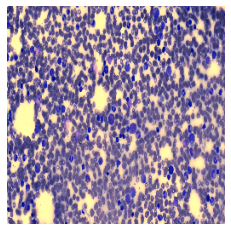

In [78]:
pic_num = 7
plt.imshow(x_test[pic_num,:,:,:])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

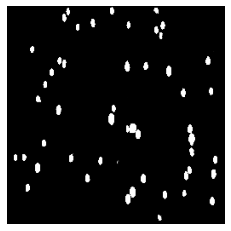

In [79]:
pred1 = pred.copy()
# pred1 = np.where(pred>0.5, 1, 0)
# print(np.unique(pred1, return_counts=True))
plt.imshow(pred1[pic_num,:,:,0], cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

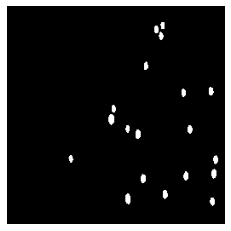

In [80]:
plt.imshow(y_test[pic_num,:,:,0], cmap='gray')
plt.axis('off')

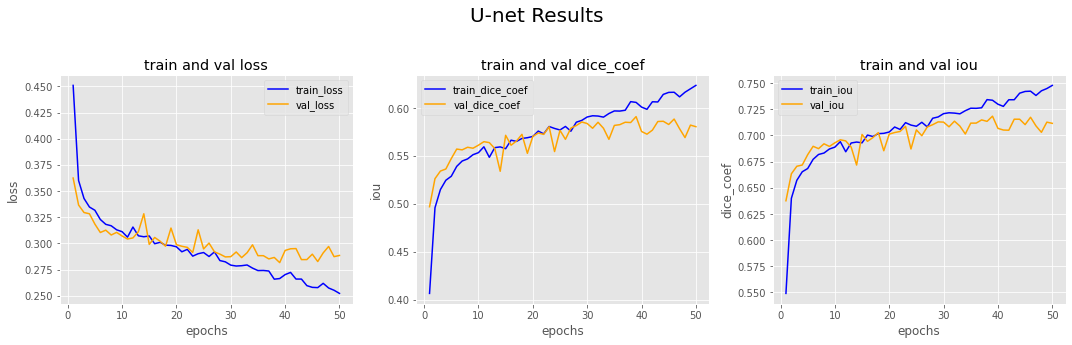

In [55]:
plt.style.use("ggplot")

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (15, 5))
plt.suptitle("U-net Results", fontsize = 20)

#graph
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

train_iou = his_dict['iou']
val_iou = his_dict['val_iou']
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(epochs, train_iou, color = 'blue', label = 'train_dice_coef')
ax2.plot(epochs, val_iou, color = 'orange', label = 'val_dice_coef')
ax2.set_title('train and val dice_coef')
ax2.set_xlabel('epochs')
ax2.set_ylabel('iou')
ax2.legend()

train_dice = his_dict['dice_coef']
val_dice = his_dict['val_dice_coef']
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(epochs, train_dice, color = 'blue', label = 'train_iou')
ax3.plot(epochs, val_dice, color = 'orange', label = 'val_iou')
ax3.set_title('train and val iou')
ax3.set_xlabel('epochs')
ax3.set_ylabel('dice_coef')
ax3.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [56]:
import datetime
now = datetime.datetime.now()
now = now.strftime('%y%m%d_%H%M%S')

# model.save('unet_model.h5')
model.save_weights('chk/unet_weights_{}'.format(now))
result = pd.DataFrame(history.history)
result.to_csv('hist/unet_history_{}.csv'.format(now))

(-0.5, 255.5, 255.5, -0.5)

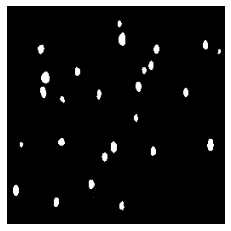

In [57]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('unet_model.h5')
# loaded_model.summary()

# model2 = UNet(input_size=x_train.shape[1:], num_cls=1)
# model2.compile(optimizer = Adam(lr), loss=dice_loss, metrics=[iou, dice_coef])
# model2.load_weights('chk/unet_weights')
# pred2 = model2.predict(x_test)
# plt.imshow(pred2[1,:,:,0], cmap='gray')
# plt.axis('off')
